# DRUGBANK DeepTraSynergy Toxicity Score Analysis #
- DeepTraSynergy paper can be found: https://academic.oup.com/bioinformatics/article/39/8/btad438/7226508

In [1]:
# Import everything needed
from matplotlib.patches import Patch
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from scipy import stats
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from toxicity_ranking import *
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import seaborn as sns

DeepTraSynergy creates toxicity score embeddings by:
1. PPIN representation
2. SMILES representations
3. Creating a similarity score by computing inner product of drug embeddings

So let's examine now how well SMILES representation similarity scores would work as a potential toxicity score. How well does SMILES similarity differentiate between toxicity category distributions (Kruskal Wallis) and is there a relationship between SMILES similarity and toxicity (Jonckheere Terpestra Test)

In [2]:
drug_combos_df = pd.read_csv('data_processed/drugbank_filtered_combos_syntox_known_targallpw.csv')
drug_combos_df

,drug_row,drug_col,cell_line_name,synergy_zip,synergy_loewe,synergy_bliss,synergy_hsa,toxicity_category
0,romidepsin,carfilzomib,EW-8,3.397628,-1.793540,2.087050,1.989756,Major
1,romidepsin,carfilzomib,EW-8,16.630494,0.941715,15.313094,5.341596,Major
2,romidepsin,carfilzomib,EW-8,14.782992,26.427238,26.653928,29.164734,Major
3,gefitinib,prazosin,TC-32,-1.670073,0.485646,2.637166,0.457076,Moderate
4,dasatinib,prazosin,TC-32,4.740410,-3.719839,9.299962,2.919795,Moderate
...,...,...,...,...,...,...,...,...
73764,saracatinib,olaparib,T24,-1.161702,0.366957,2.440150,3.080191,Major
73765,saracatinib,olaparib,TCCSUP,-9.863271,2.063146,-2.112494,3.888177,Major
73766,saracatinib,olaparib,UM-UC-3,-4.692480,0.339505,2.399012,2.031605,Major
73767,saracatinib,olaparib,VM-CUB-1,-7.821413,-8.084855,-18.212442,-18.532133,Major


There are SMILES strings in the DrugBank csv file. Collect all of the SMILES and then convert to Morgan Fingerprints, then compute the Tanimoto coefficient for drug combinatoins 

In [3]:
unique_drugs = set(drug_combos_df['drug_row'].unique())
unique_drugs = unique_drugs.union(set(drug_combos_df['drug_col'].unique()))
print(len(unique_drugs))

drugbank_df = pd.read_csv('data_processed/drugbank_drug_targets.csv')
# lowercase the drug names
drugbank_df['drug_name'] = drugbank_df['drug_name'].str.lower()
drugbank_df.dropna(subset=['SMILES'], inplace=True)

# get the SMILES for the unique_drugs
unique_drugcombo_drugs_to_smiles = {}
drugs_with_no_smiles = []
for drug in unique_drugs:
    try:
        smiles = drugbank_df[drugbank_df['drug_name'] == drug]['SMILES'].values[0]
        if smiles == 'nan' or smiles is None or smiles == np.nan:
            drugs_with_no_smiles.append(drug)
        else:
            unique_drugcombo_drugs_to_smiles[drug] = smiles
    except:
        drugs_with_no_smiles.append(drug)

print("Number of unique drugs with SMILES: ")
print(len(unique_drugcombo_drugs_to_smiles))
print("Number of unique drugs without SMILES: ")
print(len(drugs_with_no_smiles))
print("Unique drugs without SMILES: ")
print(sorted(drugs_with_no_smiles))

# Manually found remaining SMILES via PubChem website ie https://pubchem.ncbi.nlm.nih.gov/compound/Ixazomib
unique_drugcombo_drugs_to_smiles['artemether'] = 'C[C@@H]1CC[C@H]2[C@H]([C@H](O[C@H]3[C@@]24[C@H]1CC[C@](O3)(OO4)C)OC)C'
unique_drugcombo_drugs_to_smiles['carboxyamidotriazole'] = 'C1=CC(=CC=C1C(=O)C2=C(C=C(C=C2Cl)CN3C(=C(N=N3)C(=O)N)N)Cl)Cl'
unique_drugcombo_drugs_to_smiles['cudc-101'] = 'COC1=C(C=C2C(=C1)N=CN=C2NC3=CC=CC(=C3)C#C)OCCCCCCC(=O)NO'
unique_drugcombo_drugs_to_smiles['cycloguanil'] = 'CC1(N=C(N=C(N1C2=CC=C(C=C2)Cl)N)N)C'
unique_drugcombo_drugs_to_smiles['dabigatran'] = 'CN1C2=C(C=C(C=C2)C(=O)N(CCC(=O)O)C3=CC=CC=N3)N=C1CNC4=CC=C(C=C4)C(=N)N'
unique_drugcombo_drugs_to_smiles['eptifibatide'] = 'C1C[C@H]2C(=O)N[C@@H](CSSCCC(=O)N[C@H](C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N2C1)CC3=CNC4=CC=CC=C43)CC(=O)O)CCCCN=C(N)N)C(=O)N'
unique_drugcombo_drugs_to_smiles['formestane'] = 'C[C@]12CCC(=O)C(=C1CC[C@@H]3[C@@H]2CC[C@]4([C@H]3CCC4=O)C)O'
unique_drugcombo_drugs_to_smiles['indisulam'] = 'C1=CC2=C(C(=C1)NS(=O)(=O)C3=CC=C(C=C3)S(=O)(=O)N)NC=C2Cl'
unique_drugcombo_drugs_to_smiles['ivermectin'] = 'COC1CC(OC2C(C)C=CC=C3COC4C3(O)C(C=C(C4O)C)C(=O)OC3CC(CC=C2C)OC2(C3)CCC(C(O2)C(CC)C)C)OC(C1OC1CC(OC)C(C(O1)C)O)C'
unique_drugcombo_drugs_to_smiles['ixazomib'] = 'B([C@H](CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)Cl)(O)O'
unique_drugcombo_drugs_to_smiles['lumefantrine'] = 'CCCCN(CCCC)CC(O)c1cc(Cl)cc2\C(=C/c3ccc(Cl)cc3)c3cc(Cl)ccc3-c12' # https://www.ebi.ac.uk/chebi/searchId.do?chebiId=156095
unique_drugcombo_drugs_to_smiles['mebutamate'] = 'CCC(C)C(C)(COC(=O)N)COC(=O)N'
unique_drugcombo_drugs_to_smiles['meprednisone'] = 'C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@H]3C(=O)C[C@@]2([C@]1(C(=O)CO)O)C)C'
unique_drugcombo_drugs_to_smiles['metaxalone'] = 'CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C'
unique_drugcombo_drugs_to_smiles['mizoribine'] = 'C1=NC(=C(N1[C@H]2[C@@H]([C@@H]([C@H](O2)CO)O)O)O)C(=O)N'
unique_drugcombo_drugs_to_smiles['naftopidil'] = 'COC1=CC=CC=C1N2CCN(CC2)CC(COC3=CC=CC4=CC=CC=C43)O'
unique_drugcombo_drugs_to_smiles['prulifloxacin'] = 'CC1N2C3=CC(=C(C=C3C(=O)C(=C2S1)C(=O)O)F)N4CCN(CC4)CC5=C(OC(=O)O5)C'
unique_drugcombo_drugs_to_smiles['saracatinib'] = 'CN1CCN(CC1)CCOC2=CC3=C(C(=C2)OC4CCOCC4)C(=NC=N3)NC5=C(C=CC6=C5OCO6)Cl'
unique_drugcombo_drugs_to_smiles['trimethobenzamide'] = 'CN(C)CCOC1=CC=C(C=C1)CNC(=O)C2=CC(=C(C(=C2)OC)OC)OC'
unique_drugcombo_drugs_to_smiles['triptolide'] = 'CC(C)[C@@]12[C@@H](O1)[C@H]3[C@@]4(O3)[C@]5(CCC6=C([C@@H]5C[C@H]7[C@]4([C@@H]2O)O7)COC6=O)C'
unique_drugcombo_drugs_to_smiles['valspodar'] = 'C/C=C/C[C@@H](C)C(=O)[C@H]1C(=O)N[C@H](C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N1C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C)C(C)C'
unique_drugcombo_drugs_to_smiles['vorasidenib'] = 'C[C@H](C(F)(F)F)NC1=NC(=NC(=N1)C2=NC(=CC=C2)Cl)N[C@H](C)C(F)(F)F'
unique_drugcombo_drugs_to_smiles['win 55212-2'] ='CC1=C(C2=C3N1[C@@H](COC3=CC=C2)CN4CCOCC4)C(=O)C5=CC=CC6=CC=CC=C65'




598
Number of unique drugs with SMILES: 
575
Number of unique drugs without SMILES: 
23
Unique drugs without SMILES: 
['artemether', 'carboxyamidotriazole', 'cudc-101', 'cycloguanil', 'dabigatran', 'eptifibatide', 'formestane', 'indisulam', 'ivermectin', 'ixazomib', 'lumefantrine', 'mebutamate', 'meprednisone', 'metaxalone', 'mizoribine', 'naftopidil', 'prulifloxacin', 'saracatinib', 'trimethobenzamide', 'triptolide', 'valspodar', 'vorasidenib', 'win 55212-2']


In [4]:
# Get the morgan fingerprints for the unique_drugs
unique_drugcombo_drugs_to_morgan_fp = {}
for drug in unique_drugcombo_drugs_to_smiles:
    mol = Chem.MolFromSmiles(unique_drugcombo_drugs_to_smiles[drug])
    if mol is None:
        print("Error with drug: " + drug)
        continue
    else:
        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        unique_drugcombo_drugs_to_morgan_fp[drug] = morgan_fp

# Are there any drugs without a fingerprint?
drugs_without_fp = []
for drug in unique_drugcombo_drugs_to_morgan_fp:
    if np.array(unique_drugcombo_drugs_to_morgan_fp[drug]).sum() == 0:
        drugs_without_fp.append(drug)
print("Drugs without a fingerprint: ")
print(drugs_without_fp)

# For each drug combination in drug_combos_df, calculate the Tanimoto similarity between the two drugs
drug_combos_df['tanimoto_similarity'] = np.nan
for index, row in drug_combos_df.iterrows():
    drug_row = row['drug_row']
    drug_col = row['drug_col']
    morgan_fp_row = unique_drugcombo_drugs_to_morgan_fp[drug_row]
    morgan_fp_col = unique_drugcombo_drugs_to_morgan_fp[drug_col]
    tanimoto_similarity = DataStructs.TanimotoSimilarity(morgan_fp_row, morgan_fp_col)
    drug_combos_df.at[index, 'tanimoto_similarity'] = tanimoto_similarity

# Are there any drug combinations without a Tanimoto similarity?
print(len(drug_combos_df[drug_combos_df['tanimoto_similarity'].isnull()]))

Drugs without a fingerprint: 
[]
0


(array([6.3690e+03, 2.5916e+04, 2.8755e+04, 8.7910e+03, 2.4920e+03,
        2.4500e+02, 3.5600e+02, 1.1100e+02, 2.1000e+02, 3.0000e+00,
        6.2000e+01, 5.0000e+00, 2.2100e+02, 1.0000e+00, 0.0000e+00,
        5.9000e+01, 6.0000e+01, 5.2000e+01, 6.0000e+01, 1.0000e+00]),
 array([0.   , 0.043, 0.086, 0.129, 0.172, 0.215, 0.258, 0.301, 0.344,
        0.387, 0.43 , 0.473, 0.516, 0.559, 0.602, 0.645, 0.688, 0.731,
        0.774, 0.817, 0.86 ]),
 <BarContainer object of 20 artists>)

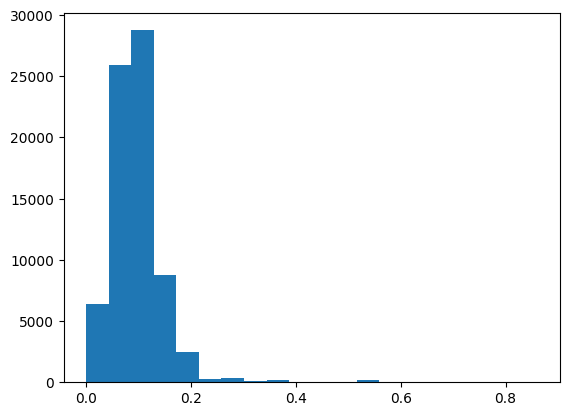

In [5]:
# Look at histogram of Tanimoto similarities
plt.hist(drug_combos_df['tanimoto_similarity'], bins=20)

- Kruskal Wallis Test
- Dunn Posthoc Test with Bonferroni Correction
- Jonckheere Terpestra Test
- ANOVA
- T Test with Bonferroni Correction

In [6]:
# Run Kruskal Wallis test on tanimoto similarity for Major, Moderate, and Minor toxicity categories

# Tanimoto similarity
major_tanimoto = drug_combos_df[drug_combos_df['toxicity_category'] == 'Major']['tanimoto_similarity'].dropna()
moderate_tanimoto = drug_combos_df[drug_combos_df['toxicity_category'] == 'Moderate']['tanimoto_similarity'].dropna()
minor_tanimoto = drug_combos_df[drug_combos_df['toxicity_category'] == 'Minor']['tanimoto_similarity'].dropna()
print(f'Major tanimoto: {len(major_tanimoto)}')
print(f'Moderate tanimoto: {len(moderate_tanimoto)}')
print(f'Minor tanimoto: {len(minor_tanimoto)}')

h_statistic_tanimoto_tox, p_value_tanimoto_tox = stats.kruskal(major_tanimoto, moderate_tanimoto, minor_tanimoto)
print(f'Kruskal-Wallis H statistic for tanimoto similarity: {h_statistic_tanimoto_tox}')
print(f'P-value for tanimoto similarity: {p_value_tanimoto_tox}')

dunn_tanimoto_tox = sp.posthoc_dunn(drug_combos_df, val_col='tanimoto_similarity', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for tanimoto similarity:' + str(dunn_tanimoto_tox))

tanimoto_major_samples = major_tanimoto.values.tolist()
tanimoto_moderate_samples = moderate_tanimoto.values.tolist()
tanimoto_minor_samples = minor_tanimoto.values.tolist()
jt_incr_tanimoto = jonckheere_terpestra_test([tanimoto_minor_samples, tanimoto_moderate_samples, tanimoto_major_samples])
print("Increasing toxicity for Tanimoto similarity: ", jt_incr_tanimoto )
jt_decr_tanimoto = jonckheere_terpestra_test([tanimoto_major_samples, tanimoto_moderate_samples, tanimoto_minor_samples])
print("Decreasing toxicity for Tanimoto similarity: ", jt_decr_tanimoto)

# Run an ANOVA on tanimoto similarity for Major, Moderate, and Minor toxicity categories
f_statistic_anova_tanimoto_tox, p_value_anova_tanimoto_tox = stats.f_oneway(major_tanimoto, moderate_tanimoto, minor_tanimoto)
print(f'ANOVA F-statistic for tanimoto similarity: {f_statistic_anova_tanimoto_tox}')
print(f'P-value for tanimoto similarity: {p_value_anova_tanimoto_tox}')

# Run a T test on tanimoto similarity between Major/Minor, Major/Moderate, and Moderate/Minor toxicity categories
major_minor_tanimoto = stats.ttest_ind(major_tanimoto, minor_tanimoto)
major_moderate_tanimoto = stats.ttest_ind(major_tanimoto, moderate_tanimoto)
moderate_minor_tanimoto = stats.ttest_ind(moderate_tanimoto, minor_tanimoto)

# Run bonferroni correction on the p-values
ttest_p_values = [major_minor_tanimoto[1], major_moderate_tanimoto[1], moderate_minor_tanimoto[1]]
ttest_p_values_corrected = multipletests(ttest_p_values, method='bonferroni')
print(f'Major/Minor T-test: {major_minor_tanimoto[1]} Corrected: {ttest_p_values_corrected[1][0]}')
print(f'Major/Moderate T-test: {major_moderate_tanimoto[1]} Corrected: {ttest_p_values_corrected[1][1]}')
print(f'Moderate/Minor T-test: {moderate_minor_tanimoto[1]} Corrected: {ttest_p_values_corrected[1][2]}')

with open('results/smiles/mfp_tox_tanimoto_drugbank.tsv', 'w') as f:
    f.write('Level\tTest\tTest statistic\tP-value\n')
    f.write(f'MFP\tKruskal-Wallis\t{h_statistic_tanimoto_tox}\t{p_value_tanimoto_tox}\n')
    f.write(f'MFP\tDunn post-hoc\tMajor/Minor\t{dunn_tanimoto_tox.iloc[0, 1]}\n')
    f.write(f'MFP\tDunn post-hoc\tMajor/Moderate\t{dunn_tanimoto_tox.iloc[0, 2]}\n')
    f.write(f'MFP\tDunn post-hoc\tModerate/Minor\t{dunn_tanimoto_tox.iloc[1, 2]}\n')
    f.write(f'MFP\tJonckheere-Terpstra Increasing toxicity\t{jt_incr_tanimoto[0]}\t{jt_incr_tanimoto[1]}\n')
    f.write(f'MFP\tJonckheere-Terpstra Decreasing toxicity\t{jt_decr_tanimoto[0]}\t{jt_decr_tanimoto[1]}\n')
    f.write(f'MFP\tANOVA\t{f_statistic_anova_tanimoto_tox}\t{p_value_anova_tanimoto_tox}\n')
    f.write(f'MFP\tT-test (bonf cor)\tMajor/Minor\t{ttest_p_values_corrected[1][0]}\n')
    f.write(f'MFP\tT-test (bonf cor)\tMajor/Moderate\t{ttest_p_values_corrected[1][1]}\n')
    f.write(f'MFP\tT-test (bonf cor)\tModerate/Minor\t{ttest_p_values_corrected[1][2]}\n')

Major tanimoto: 44355
Moderate tanimoto: 21553
Minor tanimoto: 7861
Kruskal-Wallis H statistic for tanimoto similarity: 767.3406111764361
P-value for tanimoto similarity: 2.3664831302835954e-167
Dunn post-hoc test for tanimoto similarity:                  Major          Minor       Moderate
Major      1.000000e+00  5.944241e-133   7.805914e-12
Minor     5.944241e-133   1.000000e+00  6.463602e-163
Moderate   7.805914e-12  6.463602e-163   1.000000e+00
Increasing toxicity for Tanimoto similarity:  (10.674254726769577, 0.0)
Decreasing toxicity for Tanimoto similarity:  (-10.674254726769577, 1.0)
ANOVA F-statistic for tanimoto similarity: 211.04918560825348
P-value for tanimoto similarity: 4.0155502916029915e-92
Major/Minor T-test: 1.5205919259688356e-77 Corrected: 4.561775777906507e-77
Major/Moderate T-test: 0.03233767957751621 Corrected: 0.09701303873254863
Moderate/Minor T-test: 7.958777414127797e-113 Corrected: 2.387633224238339e-112


- Violin Plot

In [7]:
colors = ['#20965D', '#FFBC42', '#D81159']
tox_order = ['Minor', 'Moderate', 'Major']
color_dict = dict(zip(tox_order, colors))
legend_elements = [
    Patch(facecolor=color_dict[cat], label = cat) for cat in tox_order
]

ax = sns.violinplot(data=drug_combos_df, x='toxicity_category', y='tanimoto_similarity', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('Drug Morgan Fingerprints Tanimoto Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/smiles/drugmfpts_v_toxcats_drugbank_violin.png', dpi=700)
plt.close()

- Strip Plot

In [8]:
ax = sns.stripplot(data=drug_combos_df, x='toxicity_category', y='tanimoto_similarity', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('Drug Morgan Fingerprints Tanimoto Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/smiles/drugmfpts_v_toxcats_drugbank_strip.png', dpi=700)
plt.close()

- Correlation Scatter Plots (Tanimoto Similarity v Synergy Scores)
- R^2 value
- Best fit line
- Pearson correlation coefficient
- Spearman correlation coefficient

In [9]:
x_ts = drug_combos_df['tanimoto_similarity']
y_bliss_true = drug_combos_df['synergy_bliss']
y_loewe_true = drug_combos_df['synergy_loewe']
y_hsa_true = drug_combos_df['synergy_hsa']
y_zip_true = drug_combos_df['synergy_zip']

####### BLISS ########
# Let's plot tanimoto similarity against bliss synergy scores
plt.scatter(x_ts, y_bliss_true)

# Best fit line
z_ts_bliss = np.polyfit(x_ts, y_bliss_true, 1)
p_ts_bliss = np.poly1d(z_ts_bliss)
y_bliss_pred = p_ts_bliss(x_ts)
r_squared_ts_bliss = r2_score(y_bliss_true, y_bliss_pred)
plt.plot(x_ts, y_bliss_pred, "r-", alpha=0.8, label=f'y = {z_ts_bliss[0]:.3f}x + {z_ts_bliss[1]:.3f}\nR² = {r_squared_ts_bliss:.3f}')

plt.xlabel('Drug Morgan Fingerprints Tanimoto Similarity')
plt.ylabel('Bliss Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/smiles/bliss_v_drugmfpts_drugbank_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between tanimoto similarity  and bliss synergy score
tanimoto_bliss_corr = x_ts.corr(y_bliss_true)
print(f'Pearson correlation coefficient between tanimoto similarity and bliss synergy score: {tanimoto_bliss_corr}')

# Calculate Spearman correlation coefficient between tanimoto similarity  and bliss synergy score
tanimoto_bliss_spearman_corr = x_ts.corr(y_bliss_true, method='spearman')
print(f'Spearman correlation coefficient between tanimoto similarity and bliss synergy score: {tanimoto_bliss_spearman_corr}')

####### HSA ########
# Let's plot tanimoto similarity against hsa synergy scores
plt.scatter(x_ts, y_hsa_true)

# Best fit line
z_ts_hsa = np.polyfit(x_ts, y_hsa_true, 1)
p_ts_hsa = np.poly1d(z_ts_hsa)
y_hsa_pred = p_ts_hsa(x_ts)
r_squared_ts_hsa = r2_score(y_hsa_true, y_hsa_pred)
plt.plot(x_ts, y_hsa_pred, "r-", alpha=0.8, label=f'y = {z_ts_hsa[0]:.3f}x + {z_ts_hsa[1]:.3f}\nR² = {r_squared_ts_hsa:.3f}')

plt.xlabel('Drug Morgan Fingerprints Tanimoto Similarity')
plt.ylabel('HSA Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/smiles/hsa_v_drugmfpts_drugbank_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between tanimoto similarity  and hsa synergy score
tanimoto_hsa_corr = x_ts.corr(y_hsa_true)
print(f'Pearson correlation coefficient between tanimoto similarity and hsa synergy score: {tanimoto_hsa_corr}')

# Calculate Spearman correlation coefficient between tanimoto similarity  and hsa synergy score
tanimoto_hsa_spearman_corr = x_ts.corr(y_hsa_true, method='spearman')
print(f'Spearman correlation coefficient between tanimoto similarity and hsa synergy score: {tanimoto_hsa_spearman_corr}')

####### LOEWE ########
# Let's plot tanimoto similarity against loewe synergy scores
plt.scatter(x_ts, y_loewe_true)

# Best fit line
z_ts_loewe = np.polyfit(x_ts, y_loewe_true, 1)
p_ts_loewe = np.poly1d(z_ts_loewe)
y_loewe_pred = p_ts_loewe(x_ts)
r_squared_ts_loewe = r2_score(y_loewe_true, y_loewe_pred)
plt.plot(x_ts, y_loewe_pred, "r-", alpha=0.8, label=f'y = {z_ts_loewe[0]:.3f}x + {z_ts_loewe[1]:.3f}\nR² = {r_squared_ts_loewe:.3f}')

plt.xlabel('Drug Morgan Fingerprints Tanimoto Similarity')
plt.ylabel('Loewe Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/smiles/loewe_v_drugmfpts_drugbank_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between tanimoto similarity  and loewe synergy score
tanimoto_loewe_corr = x_ts.corr(y_loewe_true)
print(f'Pearson correlation coefficient between tanimoto similarity and loewe synergy score: {tanimoto_loewe_corr}')

# Calculate Spearman correlation coefficient between tanimoto similarity  and loewe synergy score
tanimoto_loewe_spearman_corr = x_ts.corr(y_loewe_true, method='spearman')
print(f'Spearman correlation coefficient between tanimoto similarity and loewe synergy score: {tanimoto_loewe_spearman_corr}')

####### ZIP ########
# Let's plot tanimoto similarity against zip synergy scores
plt.scatter(x_ts, y_zip_true)

# Best fit line
z_ts_zip = np.polyfit(x_ts, y_zip_true, 1)
p_ts_zip = np.poly1d(z_ts_zip)
y_zip_pred = p_ts_zip(x_ts)
r_squared_ts_zip = r2_score(y_zip_true, y_zip_pred)
plt.plot(x_ts, y_zip_pred, "r-", alpha=0.8, label=f'y = {z_ts_zip[0]:.3f}x + {z_ts_zip[1]:.3f}\nR² = {r_squared_ts_zip:.3f}')

plt.xlabel('Drug Morgan Fingerprints Tanimoto Similarity')
plt.ylabel('ZIP Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/smiles/zip_v_drugmfpts_drugbank_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between tanimoto similarity  and zip synergy score
tanimoto_zip_corr = x_ts.corr(y_zip_true)
print(f'Pearson correlation coefficient between tanimoto similarity and zip synergy score: {tanimoto_zip_corr}')

# Calculate Spearman correlation coefficient between tanimoto similarity  and zip synergy score
tanimoto_zip_spearman_corr = x_ts.corr(y_zip_true, method='spearman')
print(f'Spearman correlation coefficient between tanimoto similarity and zip synergy score: {tanimoto_zip_spearman_corr}')

# Write all the correlations and spearman correlations to a file
with open('results/smiles/tanimoto_v_synergy_correlations_drugbank.tsv', 'w') as f:
    f.write('Synergy score\tLevel\tPearson correlation coefficient\tSpearman correlation\tR squared value\n')
    f.write(f'Bliss\tDrug MFP Tanimoto Similarity\t{tanimoto_bliss_corr}\t{tanimoto_bliss_spearman_corr}\t{r_squared_ts_bliss}\n')
    f.write(f'HSA\tDrug MFP Tanimoto Similarity\t{tanimoto_hsa_corr}\t{tanimoto_hsa_spearman_corr}\t{r_squared_ts_hsa}\n')
    f.write(f'Loewe\tDrug MFP Tanimoto Similarity\t{tanimoto_loewe_corr}\t{tanimoto_loewe_spearman_corr}\t{r_squared_ts_loewe}\n')
    f.write(f'ZIP\tDrug MFP Tanimoto Similarity\t{tanimoto_zip_corr}\t{tanimoto_zip_spearman_corr}\t{r_squared_ts_zip}\n')

Pearson correlation coefficient between tanimoto similarity and bliss synergy score: 0.019509633043064682
Spearman correlation coefficient between tanimoto similarity and bliss synergy score: 0.018860410431300104
Pearson correlation coefficient between tanimoto similarity and hsa synergy score: 0.007374939153992972
Spearman correlation coefficient between tanimoto similarity and hsa synergy score: 0.021142565385760145
Pearson correlation coefficient between tanimoto similarity and loewe synergy score: 0.10445878583673489
Spearman correlation coefficient between tanimoto similarity and loewe synergy score: 0.10583034721522658
Pearson correlation coefficient between tanimoto similarity and zip synergy score: 0.02170902124693394
Spearman correlation coefficient between tanimoto similarity and zip synergy score: 0.02752928081389676
